In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from main import train

faster_rcnn = train()

Epoch 9: 100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=10.5, rpn_cls_loss=0.0144, rpn_reg_loss=1.03, rcnn_cls_loss=0.192, rcnn_reg_loss=0.00608, accuracy=96.7]


In [3]:
import numpy as np

from helper import draw_bbox, img_to_np
from dataset_test import color_map


def visualize_rcnn(ax, rcnn_reg, rcnn_cls, img, color_map):
    rcnn_cls = F.softmax(rcnn_cls, dim=1)

    np_img = img_to_np(img)

    for rcnn_r, rcnn_c in zip(rcnn_reg, rcnn_cls):
        cls, index = torch.max(rcnn_c, dim=0)
        
        if index == 0:
            continue
        
        cls_color = color_map[0]
        if int(index) in color_map:
            cls_color = color_map[int(index)]

        np_img = draw_bbox(np_img, torch.round(rcnn_r).long(), np.array(cls_color))

    ax.imshow(np_img)
    
    
def visualize_rpn(ax, nms_reg, nms_cls, img, color_map, draw_all=False):
    nms_cls = F.sigmoid(nms_cls)

    np_img = img_to_np(img)

    for r, c in zip(nms_reg, nms_cls):
        if c >= 0.5 or draw_all:
            np_img = draw_bbox(np_img, torch.round(r).long(), [255, 255, 255])

    ax.imshow(np_img)

In [4]:
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch import autograd, nn, optim, utils

from dataset_test import Dataset, color_map
from modules.predictor import FasterRCNNPredictor

dataset = Dataset(transforms.Compose([transforms.ToTensor()]))
dataloader = utils.data.DataLoader(dataset, batch_size=4, num_workers=12, shuffle=True)

faster_rcnn_predictor = FasterRCNNPredictor(faster_rcnn).cuda()

dataloader_iter = iter(dataloader)

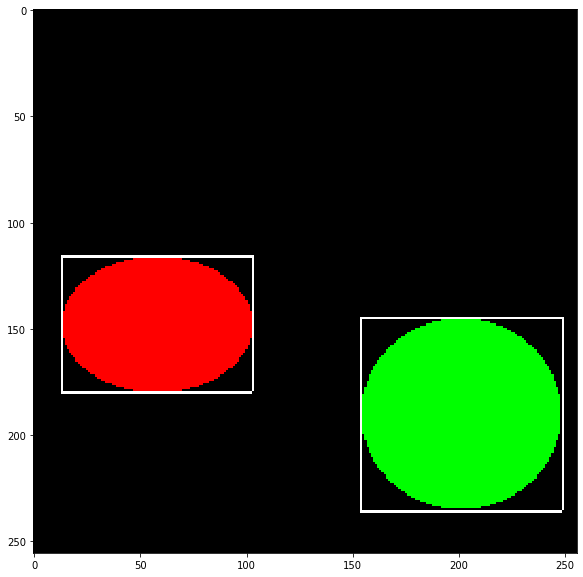

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch

img, targets, classes = next(dataloader_iter)
img = img.float().cuda()
targets = targets.detach().float().cuda()
img_id = torch.arange(0, img.size()[0])

nms_reg, nms_cls, rcnn_reg, rcnn_cls = faster_rcnn_predictor(img, img_id)

fig, ax = plt.subplots(figsize=(10, 10))
visualize_rpn(ax, nms_reg.cpu()[0], nms_cls.cpu()[0], img.cpu()[0], color_map)


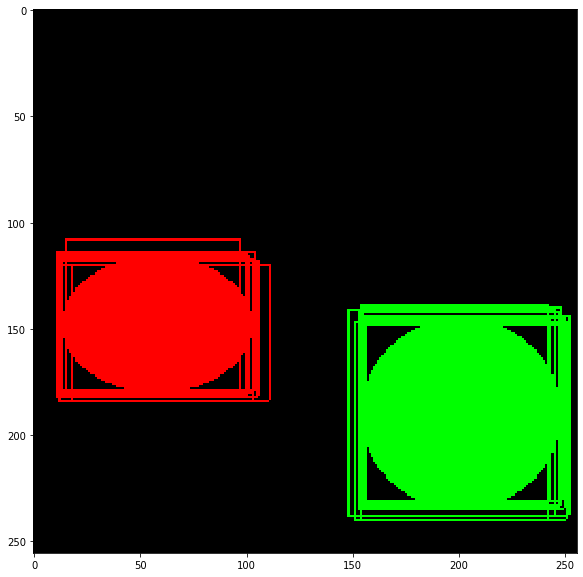

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
visualize_rcnn(ax, rcnn_reg.cpu()[0], rcnn_cls.cpu()[0], img.cpu()[0], color_map)


In [22]:
rpn_reg, rpn_cls, nms_reg, nms_cls, rcnn_reg, rcnn_cls, anchors = faster_rcnn(img, img_id)
_, _, p_rcnn_reg, p_rcnn_cls = faster_rcnn_predictor(img, img_id)

In [8]:
print(rcnn_cls.shape, rcnn_reg.shape) 

from torch.nn import functional as F

rcnn_cls_mask = F.softmax(rcnn_cls[0, :])[:, 0] < 0.1
p_rcnn_cls_mask = F.softmax(p_rcnn_cls[0, :])[:, 0] < 0.1

r = rcnn_reg[0][rcnn_cls_mask, :]
p_r = p_rcnn_reg[0][p_rcnn_cls_mask, :]
r_nms = nms_reg[0][rcnn_cls_mask, :]
r_nms_cls = nms_cls[0][rcnn_cls_mask]
print(r.shape, p_r.shape, r_nms.shape)

torch.Size([4, 300, 4]) torch.Size([4, 300, 4])
torch.Size([14, 4]) torch.Size([14, 4]) torch.Size([14, 4])


/home/tim/.conda/envs/kaggle-auto/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/home/tim/.conda/envs/kaggle-auto/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [9]:
r

tensor([[ 0.0064,  0.0503, -0.0918, -0.0199],
        [-0.1000,  0.0428, -0.0927, -0.0909],
        [ 0.0283,  0.0143,  0.1596,  0.3598],
        [ 0.2629, -0.1147,  0.1245,  0.1458],
        [-0.0118, -0.3378,  0.1523, -0.0127],
        [-0.1177, -0.4335, -0.1314, -0.0880],
        [-0.2862, -0.6322, -0.1382,  0.0007],
        [-0.1276,  0.0669, -0.0688,  0.0846],
        [-0.0212, -0.3276, -0.0763, -0.0280],
        [ 0.0933,  0.0629,  0.1165,  0.4490],
        [ 0.0934, -0.1786,  0.0923, -0.0601],
        [-0.1498, -0.0874, -0.2244,  0.1241],
        [ 0.0877,  0.0878, -0.0998,  0.5759],
        [ 0.0464,  0.2289, -0.0326,  0.1048]], device='cuda:0',
       grad_fn=<IndexBackward>)

In [10]:
p_r

tensor([[ 16.5136, 102.4387,  88.6528, 221.4493],
        [136.0022, 116.1043, 216.5823, 199.2748],
        [ 17.8090,  97.3689,  90.2166, 226.5428],
        [ 21.0343, 100.9848,  89.9593, 221.9963],
        [ 15.2463,  95.5720,  89.7450, 222.7842],
        [134.5855, 116.2582, 213.4864, 202.3663],
        [ 13.6839,  93.4266,  87.1554, 224.0526],
        [133.7881, 117.3510, 218.4931, 198.7647],
        [ 14.3059,  96.5508,  89.8923, 221.3116],
        [135.4640, 116.0272, 217.3235, 204.7352],
        [135.4735, 113.7126, 215.3831, 203.1919],
        [ 20.0165, 103.6105,  94.0456, 219.9179],
        [ 23.0144, 103.0238,  88.0183, 222.0718],
        [132.4586, 117.9729, 220.8732, 202.0614]], device='cuda:0',
       grad_fn=<IndexBackward>)

In [11]:
r_nms

tensor([[ 16.8068, 100.0594,  91.3205, 222.9107],
        [136.7312, 115.1872, 219.3582, 203.8183],
        [ 17.1120,  98.5019,  86.0889, 191.8297],
        [  5.9709, 105.1924,  80.6207, 215.2782],
        [ 20.2946, 135.1716,  87.3450, 222.6768],
        [148.2201, 136.3365, 223.2350, 207.8368],
        [ 24.9113, 150.8391,  94.1673, 225.5841],
        [150.0742, 114.6523, 222.0374, 190.1974],
        [  8.2155, 122.2062,  96.3954, 229.7575],
        [130.5913, 112.8048, 203.1138, 183.8854],
        [127.3377, 134.6583, 213.1307, 211.6780],
        [ 37.7629, 115.3950, 114.5514, 214.8996],
        [  9.7481,  97.2313,  89.4899, 171.1831],
        [122.1279,  93.8052, 220.3383, 185.1566]], device='cuda:0',
       grad_fn=<IndexBackward>)

In [12]:
F.softmax(rcnn_cls[0, rcnn_cls_mask, :])

/home/tim/.conda/envs/kaggle-auto/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[5.8181e-04, 1.2306e-01, 7.7162e-01, 1.0474e-01],
        [1.3832e-03, 1.4352e-01, 7.2462e-01, 1.3047e-01],
        [7.5676e-03, 2.1809e-01, 5.7613e-01, 1.9822e-01],
        [8.4539e-03, 2.5149e-01, 5.8020e-01, 1.5985e-01],
        [4.4113e-03, 1.9308e-01, 6.8787e-01, 1.1464e-01],
        [2.8439e-02, 1.9919e-01, 6.1194e-01, 1.6043e-01],
        [7.0215e-02, 1.8157e-01, 5.8672e-01, 1.6150e-01],
        [1.0265e-03, 1.1140e-01, 8.0576e-01, 8.1814e-02],
        [3.2258e-03, 1.5811e-01, 7.3764e-01, 1.0102e-01],
        [4.5245e-02, 2.1911e-01, 6.0717e-01, 1.2847e-01],
        [1.7211e-03, 1.5834e-01, 7.3572e-01, 1.0422e-01],
        [2.1517e-02, 1.9430e-01, 5.7375e-01, 2.1043e-01],
        [4.9092e-02, 1.8681e-01, 5.6489e-01, 1.9921e-01],
        [1.1484e-02, 2.2195e-01, 5.6988e-01, 1.9669e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [13]:
torch.sigmoid(r_nms_cls)

tensor([9.9974e-01, 9.8545e-01, 4.6872e-03, 4.5933e-03, 2.4895e-03, 1.1009e-03,
        7.8470e-04, 7.0790e-04, 6.7844e-04, 6.7101e-04, 5.9421e-04, 3.5471e-04,
        1.3466e-04, 1.9284e-05], device='cuda:0', grad_fn=<SigmoidBackward>)

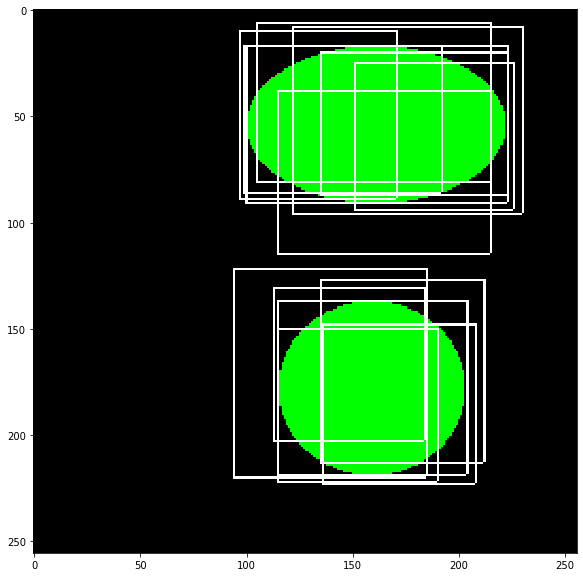

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
visualize_rpn(ax, r_nms.cpu(), r_nms_cls.cpu(), img.cpu()[0], color_map, draw_all=True)

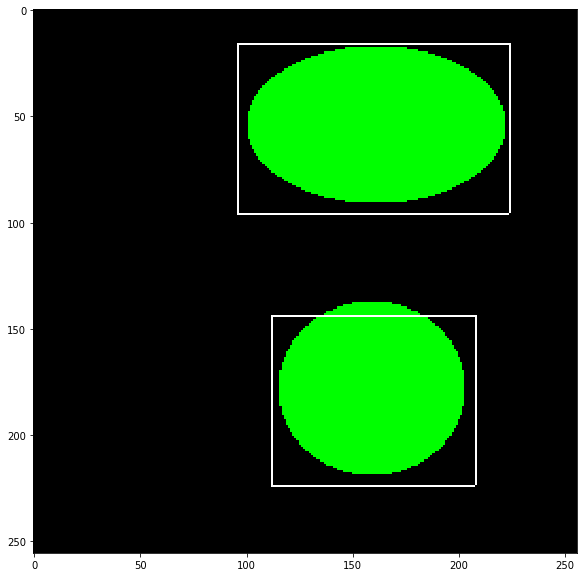

In [15]:
nms_reg_rounded = torch.round(r_nms * faster_rcnn.reduction) // faster_rcnn.reduction

fig, ax = plt.subplots(figsize=(10, 10))
visualize_rpn(ax, nms_reg_rounded.cpu()[:2], r_nms_cls.cpu()[:2], img.cpu()[0], color_map, draw_all=True)

In [16]:
rcnn_cls[0, :, 0]

tensor([-2.4492, -2.5148,  7.4183,  6.3506,  9.8927,  7.0014,  6.5531,  7.5117,
         6.5531,  8.3855,  6.7725,  9.3627,  4.7846,  7.6589, -1.4492, -1.1967,
        11.2054,  9.8359,  4.4785,  0.8485, -1.7926,  5.1718, 11.2472,  5.6088,
        11.0014,  5.6191,  4.1790, 11.9420,  5.4214,  8.1887,  5.2589,  9.4593,
         4.7343,  2.1730, -0.1467, 10.0153, 11.7442, 11.6100,  9.6058, 11.7478,
        11.8551, 11.7021, 11.8238,  7.3168, 10.8387,  6.4528,  9.8355,  1.4718,
         6.6197, 11.7559,  0.4944,  8.5054,  7.6821, 11.8250, -2.2294, -1.9069,
         5.9009,  0.3067,  3.7668, -1.9159, 12.0703,  4.1084, 12.7202, 12.7675,
        12.6949, 10.5307, 11.7931, 11.0665, 12.9057, 12.3793,  5.0632,  6.0937,
        11.7727, -0.6244,  3.3609,  6.4993,  8.8123,  4.6510,  7.9977,  8.8204,
         9.3673,  8.6410,  4.4203,  5.6581,  7.2032,  7.9698,  9.1721,  7.0302,
         6.1532,  6.8150,  4.9655,  9.8519,  0.3630,  8.2963,  3.6937, 11.2192,
         6.3772,  4.6044,  2.1505,  1.82